# (Ford GoBike Data Exploration)
## by (Nahla Nabil)

## Preliminary Wrangling

> Ford goBike dataset includes information about individual rides made in a bike-sharing system covering the greater San Francisco Bay area during Febraury 2019.
> It consists of info about trips taken by service's members, their types, their age, their gender, stations of starting and ending trips, duration of trips etc.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

### Load dataset & Quick assessing it

In [2]:
df = pd.read_csv('fordgobike.csv')
df.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip
0,52185,2019-02-28 17:32:10.1450,2019-03-01 08:01:55.9750,21.0,Montgomery St BART Station (Market St at 2nd St),37.789625,-122.400811,13.0,Commercial St at Montgomery St,37.794231,-122.402923,4902,Customer,1984.0,Male,No
1,42521,2019-02-28 18:53:21.7890,2019-03-01 06:42:03.0560,23.0,The Embarcadero at Steuart St,37.791464,-122.391034,81.0,Berry St at 4th St,37.775880,-122.393170,2535,Customer,NaN,NaN,No
2,61854,2019-02-28 12:13:13.2180,2019-03-01 05:24:08.1460,86.0,Market St at Dolores St,37.769305,-122.426826,3.0,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,5905,Customer,1972.0,Male,No
3,36490,2019-02-28 17:54:26.0100,2019-03-01 04:02:36.8420,375.0,Grove St at Masonic Ave,37.774836,-122.446546,70.0,Central Ave at Fell St,37.773311,-122.444293,6638,Subscriber,1989.0,Other,No
4,1585,2019-02-28 23:54:18.5490,2019-03-01 00:20:44.0740,7.0,Frank H Ogawa Plaza,37.804562,-122.271738,222.0,10th Ave at E 15th St,37.792714,-122.248780,4898,Subscriber,1974.0,Male,Yes


In [3]:
df.shape

(183412, 16)

In [4]:
df.describe()

,duration_sec,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bike_id,member_birth_year
count,183412.000000,183215.000000,183412.000000,183412.000000,183215.000000,183412.000000,183412.000000,183412.000000,175147.000000
mean,726.078435,138.590427,37.771223,-122.352664,136.249123,37.771427,-122.352250,4472.906375,1984.806437
std,1794.389780,111.778864,0.099581,0.117097,111.515131,0.099490,0.116673,1664.383394,10.116689
min,61.000000,3.000000,37.317298,-122.453704,3.000000,37.317298,-122.453704,11.000000,1878.000000
25%,325.000000,47.000000,37.770083,-122.412408,44.000000,37.770407,-122.411726,3777.000000,1980.000000
50%,514.000000,104.000000,37.780760,-122.398285,100.000000,37.781010,-122.398279,4958.000000,1987.000000
75%,796.000000,239.000000,37.797280,-122.286533,235.000000,37.797320,-122.288045,5502.000000,1992.000000
max,85444.000000,398.000000,37.880222,-121.874119,398.000000,37.880222,-121.874119,6645.000000,2001.000000


### Clean Data

##### Check null values

In [5]:
df.isna().sum()

duration_sec                  0
start_time                    0
end_time                      0
start_station_id            197
start_station_name          197
start_station_latitude        0
start_station_longitude       0
end_station_id              197
end_station_name            197
end_station_latitude          0
end_station_longitude         0
bike_id                       0
user_type                     0
member_birth_year          8265
member_gender              8265
bike_share_for_all_trip       0
dtype: int64

##### Drop null values

In [6]:
df.dropna(subset = ['start_station_id', 'start_station_name', 'end_station_id', 'end_station_name', 'member_birth_year', 'member_gender'] ,inplace=True)
df.shape

(174952, 16)

##### Calculate "member_age"

In [7]:
df['member_age'] = 2019 - df['member_birth_year']

##### Convert type of (start_time & end_time) into datatype  

In [8]:
df.start_time = pd.to_datetime(df.start_time)
df.end_time = pd.to_datetime(df.end_time)

##### Calculate "start_day" using: (start_time)

In [9]:
df['start_day'] = df['start_time'].apply(lambda time: time.dayofweek)

In [10]:
week_day_dict = {
    0:'Monday',
    1:'Tuesday',
    2:'Wednesday',
    3:'Thursday',
    4:'Friday',
    5:'Saturday',
    6:'Sunday'}

In [11]:
df['start_day_week_day'] = df['start_day'].map(week_day_dict)

##### Calculate "distance_km" using:
- **(start_station_latitude, start_station_longitude, end_station_latitude & end_station_longitude)**

In [12]:
# approximate radius of earth in km
R = 6373.0

def disance_km_between_lon_lat(lat1, lon1, lat2, lon2):
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a ))

    return R * c

In [13]:
df['distance_km'] = disance_km_between_lon_lat(df['start_station_latitude'], df['start_station_longitude'], df['end_station_latitude'], df['end_station_longitude'])

##### Calculate "duration_min"  

In [14]:
df['duration_min'] = df['duration_sec']/60

##### Quick assessing data

In [15]:
df.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,...,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip,member_age,start_day,start_day_week_day,distance_km,duration_min
0,52185,2019-02-28 17:32:10.145,2019-03-01 08:01:55.975,21.0,Montgomery St BART Station (Market St at 2nd St),37.789625,-122.400811,13.0,Commercial St at Montgomery St,37.794231,...,4902,Customer,1984.0,Male,No,35.0,3,Thursday,32.266374,869.750000
2,61854,2019-02-28 12:13:13.218,2019-03-01 05:24:08.146,86.0,Market St at Dolores St,37.769305,-122.426826,3.0,Powell St BART Station (Market St at 4th St),37.786375,...,5905,Customer,1972.0,Male,No,47.0,3,Thursday,176.721819,1030.900000
3,36490,2019-02-28 17:54:26.010,2019-03-01 04:02:36.842,375.0,Grove St at Masonic Ave,37.774836,-122.446546,70.0,Central Ave at Fell St,37.773311,...,6638,Subscriber,1989.0,Other,No,30.0,3,Thursday,17.306748,608.166667
4,1585,2019-02-28 23:54:18.549,2019-03-01 00:20:44.074,7.0,Frank H Ogawa Plaza,37.804562,-122.271738,222.0,10th Ave at E 15th St,37.792714,...,4898,Subscriber,1974.0,Male,Yes,45.0,3,Thursday,164.004984,26.416667
5,1793,2019-02-28 23:49:58.632,2019-03-01 00:19:51.760,93.0,4th St at Mission Bay Blvd S,37.770407,-122.391198,323.0,Broadway at Kearny,37.798014,...,5200,Subscriber,1959.0,Male,No,60.0,3,Thursday,199.317120,29.883333


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 174952 entries, 0 to 183411
Data columns (total 21 columns):
duration_sec               174952 non-null int64
start_time                 174952 non-null datetime64[ns]
end_time                   174952 non-null datetime64[ns]
start_station_id           174952 non-null float64
start_station_name         174952 non-null object
start_station_latitude     174952 non-null float64
start_station_longitude    174952 non-null float64
end_station_id             174952 non-null float64
end_station_name           174952 non-null object
end_station_latitude       174952 non-null float64
end_station_longitude      174952 non-null float64
bike_id                    174952 non-null int64
user_type                  174952 non-null object
member_birth_year          174952 non-null float64
member_gender              174952 non-null object
bike_share_for_all_trip    174952 non-null object
member_age                 174952 non-null float64
start_day        

### What is the structure of your dataset?
> There are 174,952 trips in the dataset with 21 features (duration_sec, start_time, end_time, start_station_id, start_station_name, start_station_latitude, start_station_longitude, end_station_id, end_station_name, end_station_latitude ,end_station_longitude, bike_id, user_type, member_birth_year, member_gender, bike_share_for_all_trip, member_age, start_day, start_day_week_day, distance, duration_min ). Out of 21 specifications 13 are numerical, 2 are datetime & 6 are object type.

### What is/are the main feature(s) of interest in your dataset?
> I'm most interested in figuring out features that affect using the bike-sharing system the most:
- day of week
- the average trip time
- type of users
- age
- gender 

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?
> I think what will help support my investigation are:
- start_day_week_day
- duration_sec, duration_min
- user_type
- member_age
- member_gender


## Univariate Exploration

### Check unusal points & outliers

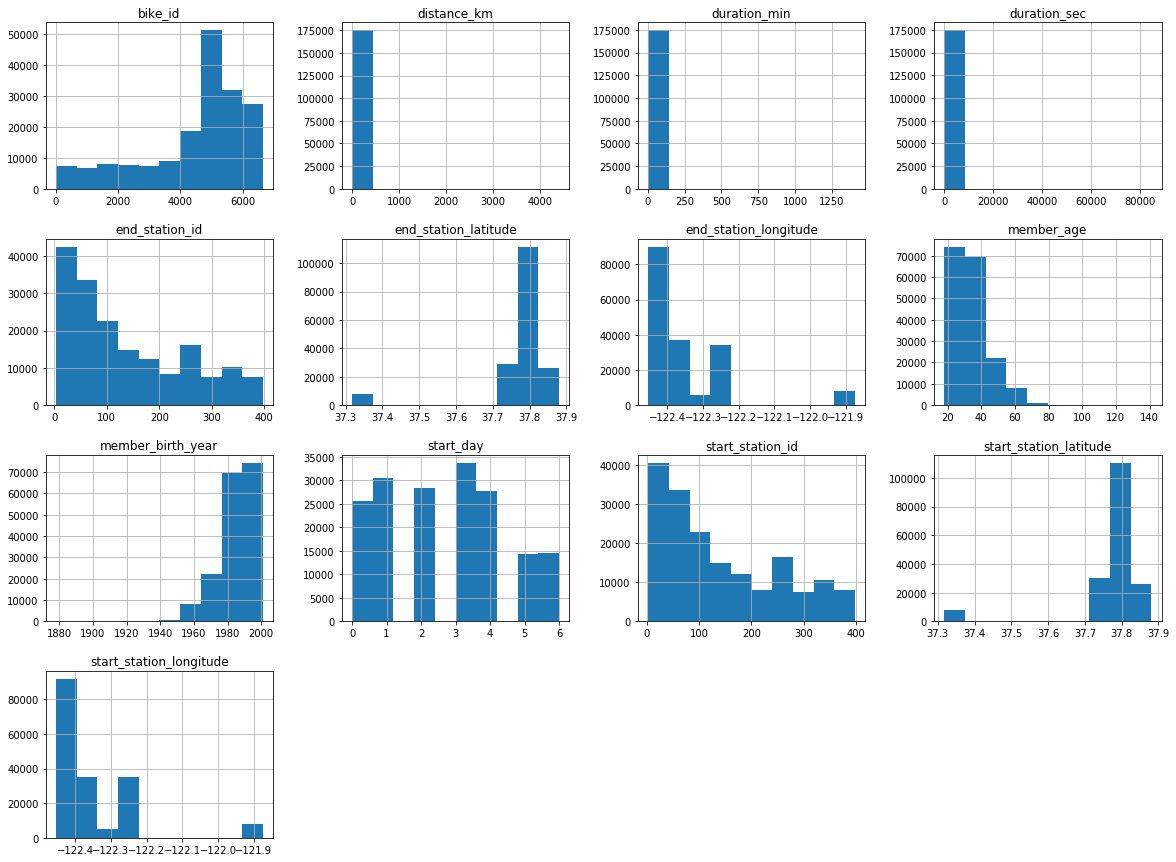

In [17]:
df.hist(figsize=(20,15));

According to the Histogram, there are some outliers in many features:
- member_age & member_birth_year (as they are connected)
- distance_km
- duration_sec

###### Check outliers of member_age

In [18]:
df['member_age'].describe()

count    174952.000000
mean         34.196865
std          10.118731
min          18.000000
25%          27.000000
50%          32.000000
75%          39.000000
max         141.000000
Name: member_age, dtype: float64

In [19]:
print('All:', df['member_age'].count())
print('More than 70:', df[(df['member_age']>70)]['member_age'].count())
print('Percent of more than 70:', (df[(df['member_age']>70)]['member_age'].count()/df['member_age'].count() *100), '%')

All: 174952
More than 70: 575
Percent of more than 70: 0.32866157574649046 %


In [20]:
#cut off age greater than 70's
df = df[(df.member_age < 70)]

###### Check outliers of distance_km

In [21]:
df['distance_km'].describe()

count    174278.000000
mean        107.618263
std          69.429652
min           0.000000
25%          57.959565
50%          90.387415
75%         141.513095
max        4407.175663
Name: distance_km, dtype: float64

In [22]:
print('All:', df['distance_km'].count())
print('------------------------------------------')

print('Less than or equal 0:', df[(df['distance_km']<=0)]['distance_km'].count())
print('Percent of less than or equal 0:', (df[(df['distance_km']<=0)]['distance_km'].count()/df['distance_km'].count() *100), '%')

print('------------------------------------------')

print('More than 400 KM:', df[(df['distance_km']>400)]['distance_km'].count())
print('Percent of more than 400 KM:', (df[(df['distance_km']>400)]['distance_km'].count()/df['distance_km'].count() *100), '%')

All: 174278
------------------------------------------
Less than or equal 0: 3439
Percent of less than or equal 0: 1.9732840633929698 %
------------------------------------------
More than 400 KM: 288
Percent of more than 400 KM: 0.16525321612595967 %


In [23]:
#cut off distance larger than 400 km & less than 0 km
df = df[(df.distance_km > 0)]
df = df[(df.distance_km < 400)]

###### Check outliers of duration_sec

In [24]:
df['duration_sec'].describe()

count    170551.000000
mean        680.050313
std        1536.159157
min          61.000000
25%         323.000000
50%         507.000000
75%         777.000000
max       84548.000000
Name: duration_sec, dtype: float64

In [25]:
print('All:', df['duration_sec'].count())
print('------------------------------------------')

print('Less than 100:', df[(df['duration_sec']<100)]['duration_sec'].count())
print('Percent of less than 100:', (df[(df['duration_sec']<100)]['duration_sec'].count()/df['duration_sec'].count() *100), '%')

print('------------------------------------------')

print('More than 3000:', df[(df['duration_sec']>3000)]['duration_sec'].count())
print('Percent of more than 3000:', (df[(df['duration_sec']>3000)]['duration_sec'].count()/df['duration_sec'].count() *100), '%')

All: 170551
------------------------------------------
Less than 100: 1046
Percent of less than 100: 0.6133062837509016 %
------------------------------------------
More than 3000: 1464
Percent of more than 3000: 0.8583942632995408 %


In [26]:
#cut off less than 100 & more than 3000
df = df[(df.duration_sec > 100)]
df = df[(df.duration_sec < 3000)]

### Visualize & investigate distributions of individual variables

#### Investigate Users' age 

In [27]:
df['member_age'].describe()

count    167988.000000
mean         34.022365
std           9.632052
min          18.000000
25%          27.000000
50%          32.000000
75%          39.000000
max          69.000000
Name: member_age, dtype: float64

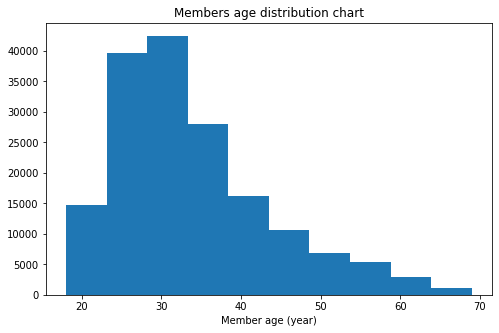

In [28]:
plt.figure(figsize = [8, 5]) 

bins = np.arange(10, df['member_age'].max()+4, 4)

plt.hist(data=df, x='member_age')

plt.title("Members age distribution chart")
plt.xlabel('Member age (year)')

plt.show()

By looking to the previous Histogram, it's obvious that age in years is normally distributed. We also can notice that values started to increase from almost 18 years to almost 30 years then suddenly decreased. We also may notice there's a high peak around 25 to 35 years.

#### Investigate Users' type 

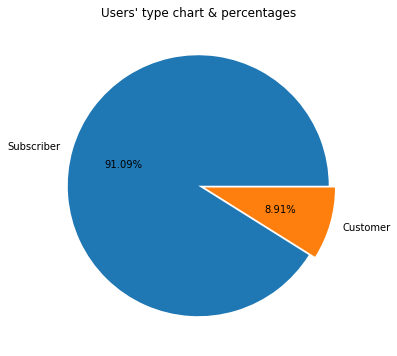

In [29]:
df.user_type.value_counts().plot.pie(figsize=(6,6), autopct='%.2f%%', explode=(0, .05))
plt.title("Users' type chart & percentages")
plt.ylabel('')
plt.show()

Users who use this rent system are divded into **Subscribers** or **Customers**:
- Large segment of users were **Subscribers** with 90.86%
- Regular **Customers** were about 9.14% of overall users

#### Investigate Users' gender 

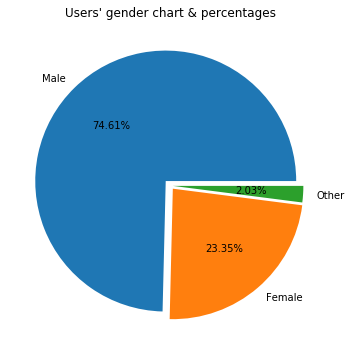

In [30]:
df.member_gender.value_counts().plot.pie(figsize=(6,6), autopct='%.2f%%', explode=(0.05, .03, 0.02))
plt.title("Users' gender chart & percentages")
plt.ylabel('')
plt.show()

Users who use this rent system are divded into **Males**, **Females** or **Others**:
- Large segment of users are **Males** with 74.61%
- **Females** who used this system were about 23.36%
-  Not-defined gender **Others** were about 2.03% of overall users

#### Investigate start_day 

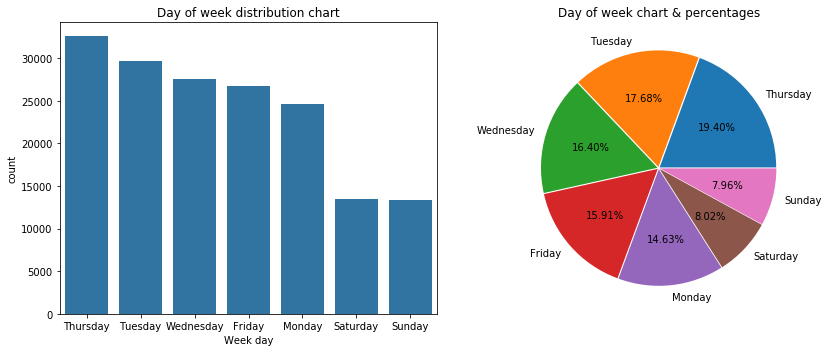

In [31]:
plt.subplot(1, 2, 1)
sb.countplot(data=df, x='start_day_week_day', color=sb.color_palette()[0], order=df['start_day_week_day'].value_counts().index)
plt.title("Day of week distribution chart")
plt.xlabel('Week day')

plt.subplot(1, 2, 2)
df.start_day_week_day.value_counts().plot.pie(figsize=(12,5), autopct='%.2f%%', explode=(0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01))
plt.title("Day of week chart & percentages")
plt.ylabel('')

plt.tight_layout()
plt.show()

According to start days, it's obvious that this system is used more during **weekdays** than **weekends**. By looking to the charts, we can see that days are ordered descending from most active days to least by the following percentages:
- Thursday: 19.34%
- Tuesday: 17.60%
- Wednesday: 16.33%
- Friday: 15.87%
- Monday: 14.64%
- Saturday: 8.13%
- Sunday: 8.10%

#### Investigate Duration in min 

In [32]:
df['duration_min'].describe()

count    167988.000000
mean         10.090534
std           6.698409
min           1.683333
25%           5.416667
50%           8.433333
75%          12.833333
max          49.950000
Name: duration_min, dtype: float64

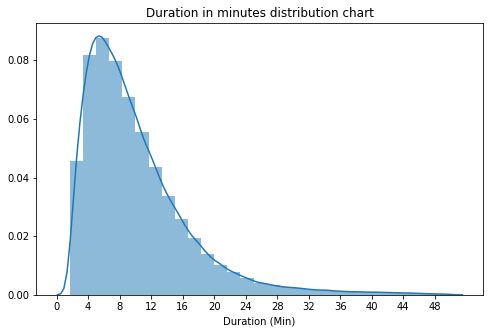

In [33]:
plt.figure(figsize = [8, 5]) 

bins = np.arange(0, df['duration_min'].max() + 10/6, 10/6)

sb.distplot(df['duration_min'], kde=True, bins =bins, hist_kws = {'alpha' : 0.5})

plt.xticks(np.arange(0, 51, step=4))
plt.xlabel('Duration (Min)')
plt.title('Duration in minutes distribution chart')

plt.show()

By looking to the previous Histogram, it's obvious that duration in minutes is normally distributed. We also can notice that values started to increase from 1 minute to almost 8 minutes then suddenly decreased. We also may notice there's a high peak around 6 to 10 minutes.

#### Investigate Distance in KM 

In [34]:
df['distance_km'].describe()

count    167988.000000
mean        109.634989
std          65.733951
min           0.922381
25%          60.796882
50%          91.984745
75%         143.316661
max         398.211121
Name: distance_km, dtype: float64

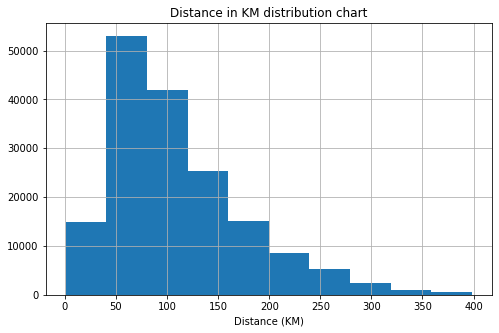

In [35]:
plt.figure(figsize = [8, 5]) 

df['distance_km'].hist()

plt.xlabel('Distance (KM)')
plt.title('Distance in KM distribution chart')

plt.show()

By looking to the previous Histogram, it's obvious that dictance in km is normally distributed. We also can notice that values started to increase from almost 1 km to almost 90 km then suddenly decreased. We also may notice there's a high peak around 85 to 95 km.

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?
> For **member_age**, it is normally distributed. We noticed that values started to increase from almost 18 years to almost 30 years then suddenly decreased. We also noticed there's a high peak around 25 to 35 years.
>
> For **users_type** Subscribers or Customers:
- Large segment of users were **Subscribers** with 90.86%
- Regular **Customers** were about 9.14% of overall users
> 
> For **users_gender**, they are divded into Males, Females or Others:
- Large segment of users are **Males** with 74.61%
- **Females** who used this system were about 23.36%
- Not-defined gender **Others** were about 2.03% of overall users
> 
> According to **start days**, it's obvious that this system is used more during weekdays than weekends. By looking to the charts, we can see that days are ordered descending from most active days to least by the following percentages:
- Thursday: 19.34%
- Tuesday: 17.60%
- Wednesday: 16.33%
- Friday: 15.87%
- Monday: 14.64%
- Saturday: 8.13%
- Sunday: 8.10%
> 
> For **duration_min**, it is normally distributed. We noticed that values started to increase from 1 minute to almost 8 minutes, then suddenly decreased. There's a high peak around 6 to 10 minutes.
> 
> For **dictance_km**, it is normally distributed. We noticed that values started to increase from 1 km to almost 90 km then suddenly decreased. There's a high peak around 85 to 95 km.
>
> Overall, we can say that users who are using this system the most, are in their **30s**, their type is **subscribers**, mostly are **males** ,using it during **weekdays** not weekends



### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?
> I calculated some features such as:
- member_age
- duration_min
- distance_km between start & end area
>
> There were some unusual points & outliers in many features:
- **member_age** & **member_birth_year** there was years before 1950s and ages greater than 70s
- **distance_km**, some values where equal to 0 km & others greater than 400 km
- **duration_sec**, some values were irrational, as some trips were recorded with less than 100 seconds while others were more than a whole day

## Bivariate Exploration

#### Investigat & visualize Distance (km) & Duration (min)

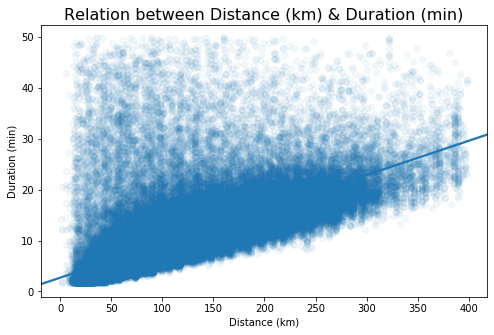

In [36]:
plt.figure(figsize = [8, 5])

sb.regplot(data = df, x = 'distance_km', y = 'duration_min', scatter_kws={'alpha':0.05})

plt.title('Relation between Distance (km) & Duration (min)', fontsize =16)
plt.xlabel('Distance (km)')
plt.ylabel('Duration (min)')

plt.show()

The regression line in a scatter plot showing a **positive correlation** between **Distance (km)** & **Duration (min)** , which make sense that long distances trips take more time.

#### Investigat & visualize Days &  duration (min)

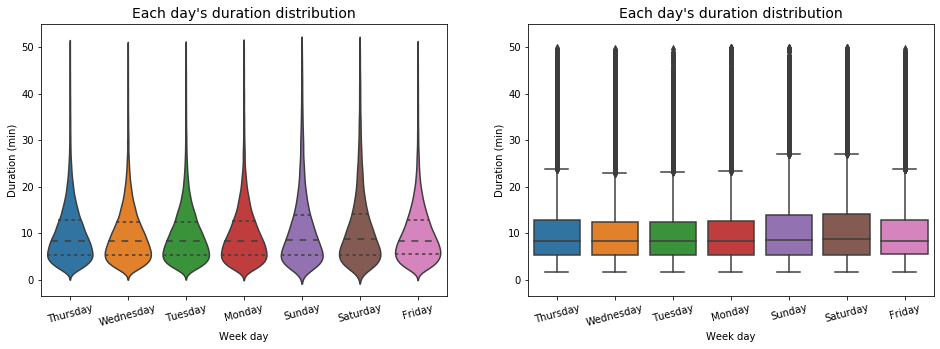

In [37]:
plt.figure(figsize = [16, 5])

# LEFT plot: violin plot
plt.subplot(1, 2, 1)

ax1 = sb.violinplot(data=df, x='start_day_week_day', y='duration_min', inner = 'quartile')

plt.title('Each day\'s duration distribution', fontsize =14)

plt.xticks(rotation=15)
plt.xlabel('Week day')
plt.ylabel('Duration (min)')

# RIGHT plot: box plot
plt.subplot(1, 2, 2)

sb.boxplot(data=df, x='start_day_week_day', y='duration_min')

plt.title('Each day\'s duration distribution', fontsize =14)

plt.xticks(rotation=15)
plt.xlabel('Week day')
plt.ylabel('Duration (min)')
plt.ylim(ax1.get_ylim())

plt.show()

Three lines that's plotted within each violin area, are the three middle quartiles. The line with thick dashes indicates the median ~= 8 for all days in the week, which is the same for all days of the week.

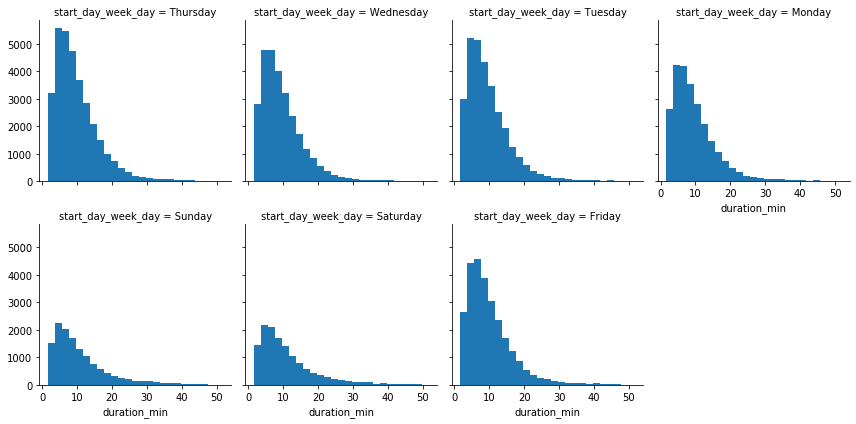

In [38]:

bin_edges = np.arange(df['duration_min'].min(), df['duration_min'].max()+2, 2)

g = sb.FacetGrid(data = df, col = 'start_day_week_day', col_wrap=4, sharey=True)
g.map(plt.hist, 'duration_min', bins = bin_edges)

plt.show()

From the previous Histogram, it's obvious that some days [Thursday, Wednesday, Tuesday, Monday, Friday] rides were more than the others [Sunday, Saturday] but generally, most rides' duration were ~= 8 minutes for each. Overall, duration in minutes are normally distributed for all dayes, values started to increase from 1 min to almost 8 min then suddenly decreased. We also may notice there's a high peak around 8 to 10 min.

#### Investigat & visualize each Gender with User's type

In [39]:
gt_counts = df.groupby(['member_gender', 'user_type']).size()
gt_counts = gt_counts.reset_index(name='count')
gt_counts = gt_counts.pivot(index = 'member_gender', columns = 'user_type', values = 'count')
gt_counts

user_type,Customer,Subscriber
member_gender,,
Female,4093,35140
Male,10468,114874
Other,412,3001


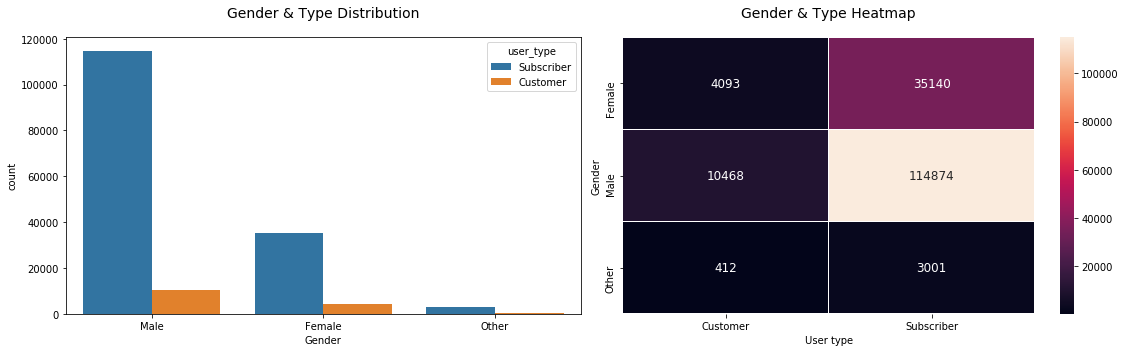

In [40]:
plt.figure(figsize = [16, 5])

# LEFT plot: violin plot
plt.subplot(1, 2, 1)

sb.countplot(data = df, x = 'member_gender', hue = 'user_type')

plt.title('Gender & Type Distribution', fontsize =14, pad=20)

plt.xlabel('Gender')


# RIGHT plot: box plot
plt.subplot(1, 2, 2)

sb.heatmap(gt_counts, annot=True, fmt="d", annot_kws={'size':12}, linewidths=.5)

plt.title('Gender & Type Heatmap', fontsize =14, pad=20)

plt.xlabel('User type')
plt.ylabel('Gender')

plt.tight_layout()

plt.show()

- From graphs, we can indicate that Subscribers are always larger than Customers for all 3 gender types.
- Most **Subscribers** are Males = 114874 **male-subscriber**, followed by 35140 **female-Subscriber**, then the least number of Subscribers are 3001 **other-subscriber**.
- For **Customers**, Most of them are Males = 10468 **male-customer**, then 4093 **female-customer** & the least are 412 **other-customer**

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?
> There's a **positive correlation** between **Distance (km)** & **Duration (min)** , which make sense that long distances trips take more time.
>
>Some days [Thursday, Wednesday, Tuesday, Monday, Friday], weekdays, rides were more than the others [Sunday, Saturday], weekends. But generally, most rides' duration were ~= 8 minutes for each.
>
> According to **users type**, Subscribers are always larger than Customers for all 3 gender types.
> Most **Subscribers** are Males = 114874 **male-subscriber**, followed by 35140 **female-Subscriber**, then the least number of Subscribers are 3001 **other-subscriber**.
> For **Customers**, Most of them are Males = 10468 **male-customer**, then 4093 **female-customer** & the least are 412 **other-customer**

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?
> There is relation between **start_station_latitude**, **start_station_longitude**, **end_station_latitude** & **end_station_longitude** and **duration**



## Multivariate Exploration

#### Weekly rides by user type & gender

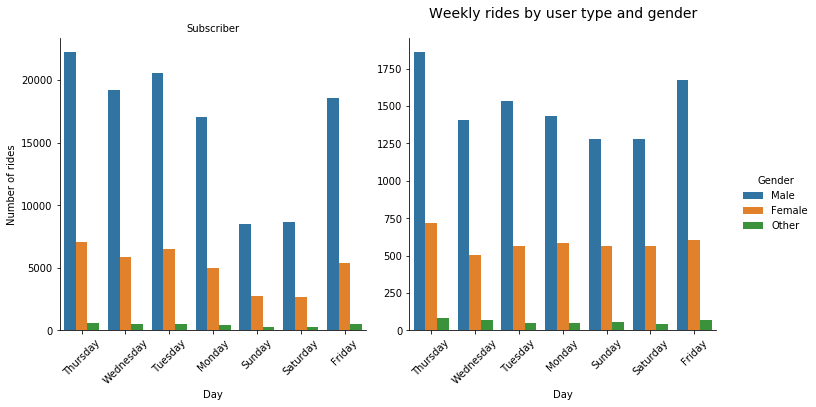

In [41]:
g = sb.catplot(data=df, x='start_day_week_day', col="user_type", hue="member_gender", kind='count', sharey = False)
g.set_axis_labels("Day", "Number of rides")

g._legend.set_title('Gender')
g.set_titles("{col_name}")

plt.title('Weekly rides by user type and gender', fontsize=14, pad=20)

for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

plt.show()

- Number of rides for both **Male-Customers** & **Male-Subscribers** increases during weekdays but are less during weekends.
- Number of rides for **Female-Subscribers** also increases during weekdayse but decreases during weekends.
- **Female-Subscribers** are less than **Males**, with large difference.
- **Female-Customers** just increases in **Thursday**, while decreases & almost still the same the whole week.
- **Others-Subscribers** increases during weekdays & decreases during weekends.
- **Others-Customers** increases in **Thursdays, Wednesdays & Fridays**, but decreases and still the same for **Tuesdays, Mondays, Sundays & Saturdays**.

#### Relation between user type across distance & age

In [42]:
def hist2dgrid(x, y, **kwargs):
    palette = kwargs.pop('color')
    plt.hist2d(x, y, cmap = palette, cmin = 0.5)

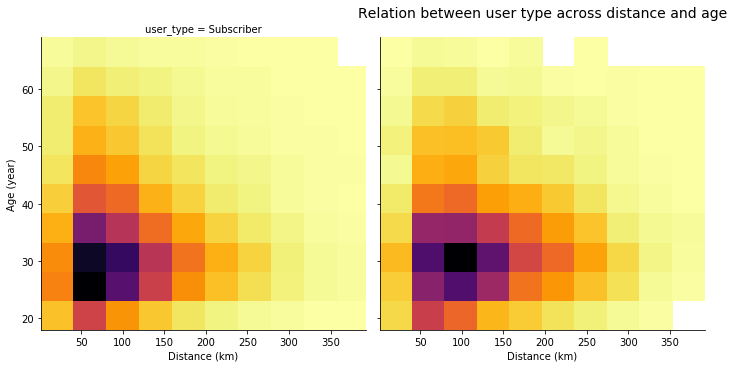

In [44]:
g = sb.FacetGrid(data = df, col = 'user_type', col_wrap = 2, size = 5)
g.map(hist2dgrid, 'distance_km', 'member_age', color = 'inferno_r')

plt.title('Relation between user type across distance and age', fontsize=14, pad=20)

g.set_xlabels('Distance (km)')
g.set_ylabels('Age (year)')

plt.show()

- For **Subscribers**: Most rides are of distance **~50 km**, which are taken by users of age ~25:30, then ~27:33
- Followed by rides of distance **~100 km**, which are taken by users of age ~27:33, then ~25:30
- For **Customers**: Most rides are of distance **~100 km**, which are taken by users of age ~27:33
- Followed by rides of distance **~50:150 km**, which are taken by users of age ~25:33
- For Long distance number of old users -of age more than 30s- are less than others who take small distances

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> There is a relation between duration, distance and week days.
> There is negative correlation between distance and age

### Were there any interesting or surprising interactions between features?

> Number of rides for both **Male-Customers** & **Male-Subscribers** increases during weekdays but are less during weekends.
> Number of rides for **Female-Subscribers** also increases during weekdayse but decreases during weekends.
> **Female-Subscribers** are less than **Males**, with large difference.
> **Female-Customers** just increases in **Thursday**, while decreases & almost still the same the whole week.
> **Others-Subscribers** increases during weekdays & decreases during weekends.
> **Others-Customers** increases in **Thursdays, Wednesdays & Fridays**, but decreases and still the same for **Tuesdays, Mondays, Sundays & Saturdays**.
> 
- For **Subscribers**: Most rides are of distance **~50 km**, which are taken by users of age ~25:30, then ~27:33
- Followed by rides of distance **~100 km**, which are taken by users of age ~27:33, then ~25:30
- For **Customers**: Most rides are of distance **~100 km**, which are taken by users of age ~27:33
- Followed by rides of distance **~50:150 km**, which are taken by users of age ~25:33
- For Long distance number of old users -of age more than 30s- are less than others who take small distances

### References
- https://www.kaggle.com/chirag02/ford-gobike-2019feb-tripdata
- https://kanoki.org/2019/12/27/how-to-calculate-distance-in-python-and-pandas-using-scipy-spatial-and-distance-functions/
- https://seaborn.pydata.org/generated/seaborn.heatmap.html
- https://github.com/mwaskom/seaborn/issues/867